In [146]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from collections import defaultdict
from urllib import request
import os
import pandas as pd
import numpy as np
from urllib import request
import cv2
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dropout,Dense
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import os
from tensorflow.keras.applications import VGG16
import json
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
import tensorflow
import tensorflow as tf
from collections import deque
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
tf.compat.v1.keras.applications.imagenet_utils.decode_predictions
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [147]:
file_path='C:/Users/Winner/OneDrive/Documents/AI Hackathon/MDataset/input'

# Train test validation split

In [148]:
!pip install split_folders

In [149]:
import splitfolders
splitted_folder='C:/Users/Winner/OneDrive/Documents/AI Hackathon/MDataset/output'
def train_test_valid(train_size=0.7,test_size=0.2,val_size=0.1,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  val_size = val_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(file_path,splitted_folder, seed = 1337, ratio = (train_size,test_size,val_size), group_prefix = None)
train_test_valid()

Copying files: 530 files [00:03, 170.82 files/s]


In [150]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_file_path = 'C:/Users/Winner/OneDrive/Documents/AI Hackathon/MDataset/output/train'
test_file_path =  'C:/Users/Winner/OneDrive/Documents/AI Hackathon/MDataset/output/test'
val_file_path =  'C:/Users/Winner/OneDrive/Documents/AI Hackathon/MDataset/output/val'

def data_pre_processing(valid_split = 0,input_size = (260, 260),image_color = 'rgb',batch_size = 32,
                        shuffle=True):


    train_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split,fill_mode='nearest',rotation_range=40,horizontal_flip=True)

    validation_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split)

    test_gen=ImageDataGenerator(rescale=1/255.0)

    train_data=train_gen.flow_from_directory(directory=train_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    test_data=test_gen.flow_from_directory(directory=test_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    valid_data=validation_gen.flow_from_directory(directory=val_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    return train_data,test_data,valid_data

train,test,validation=data_pre_processing()

Found 370 images belonging to 3 classes.
Found 55 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


# Data exploration

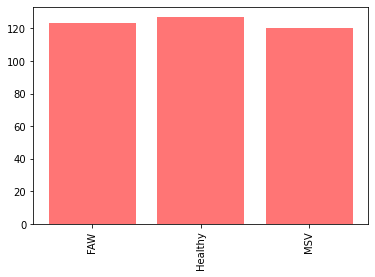

In [151]:
values_counter=Counter(train.classes)
sorted(values_counter.items())
plt.bar(train.class_indices.keys(), values_counter.values(), color=(1, 0.1, 0.1, 0.6))
plt.xticks(rotation=90)
plt.show()

In [152]:
labels=dict()
for label_name,label_num in train.class_indices.items():
        labels[label_num]=label_name

100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


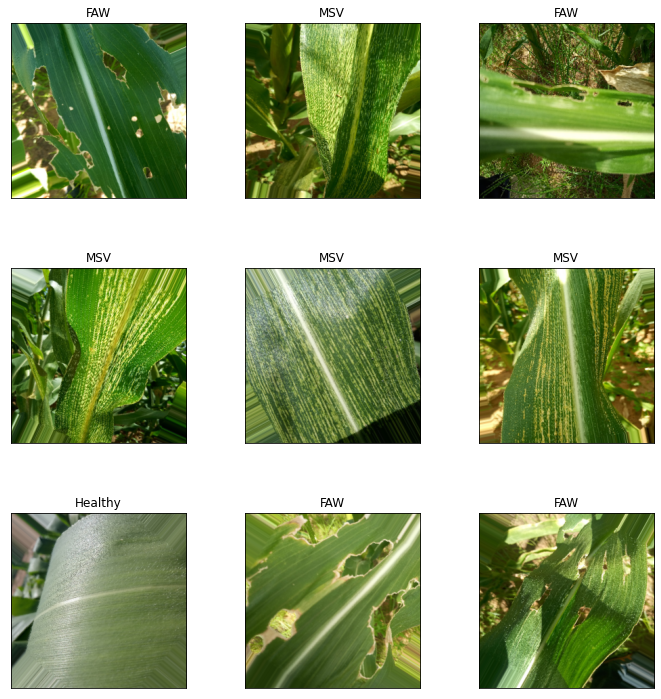

In [153]:
plt.figure(figsize=(10,10))
for i in tqdm(range(9)):
    plt.subplot(3,3,i+1)
    for x_batch,y_batch in train:
        image=x_batch[0]
        argmax=np.argmax(y_batch)
        plt.tight_layout(h_pad=5)
        plt.title(labels[argmax])
        plt.xticks(())
        plt.yticks(())
        plt.imshow(image)
        break

# Create Model

In [154]:
!pip install  efficientnet
import efficientnet.tfkeras as enet

In [155]:
def configure_model():
  inputs_1 = tf.keras.Input(shape=(260, 260, 3))
  mymodel=enet.EfficientNetB2(input_shape = (260, 260, 3), include_top = False, weights = 'imagenet')
  x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(mymodel.output)
  x = tf.keras.layers.Flatten()(x)
  predictors = tf.keras.layers.Dense(3,activation='softmax',name='Predictions')(x)
  final_model = Model(mymodel.input, outputs=predictors)
  return final_model
final_model=configure_model()

In [156]:
def model(new_model=final_model,layers_num=1,trainable=False):
    for layer in new_model.layers[:layers_num]:
        layer.trainable=trainable
    return new_model
final_model=model(final_model)

In [157]:
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [158]:
opt=tf.keras.optimizers.Adam(0.0001)
final_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [159]:
def callbacks(patience=2):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,min_delta=0.001)
    lr=tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks_list=[checkpoint, early,lr]
    return callbacks_list

In [160]:
callbacks=callbacks()

In [161]:
counter = Counter(train.classes)                          
max_val = float(max(counter.values()))       
class_weights1 = {class_id : max_val/num_images for class_id, num_images in counter.items()}   

In [162]:
hist=final_model.fit(train,epochs=50,validation_data=(validation),callbacks=callbacks,class_weight=class_weights1)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.6973
Epoch 1: val_loss improved from inf to 0.58301, saving model to my_model.h5
12/12 [==============================] - 133s 10s/step - loss: 0.8482 - accuracy: 0.6973 - val_loss: 0.5830 - val_accuracy: 0.8476 - lr: 1.0000e-04
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.9595
Epoch 2: val_loss improved from 0.58301 to 0.28879, saving model to my_model.h5
12/12 [==============================] - 111s 9s/step - loss: 0.3507 - accuracy: 0.9595 - val_loss: 0.2888 - val_accuracy: 0.9238 - lr: 1.0000e-04
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9568
Epoch 3: val_loss improved from 0.28879 to 0.21766, saving model to my_model.h5
12/12 [==============================] - 92s 8s/step - loss: 0.1648 - accuracy: 0.9568 - val_loss: 0.2177 - val_accuracy: 0.9429 - lr: 1.0000e-04
Epoch 4/50
12/12 [=======================

12/12 [==============================] - 76s 7s/step - loss: 0.0124 - accuracy: 0.9973 - val_loss: 0.0197 - val_accuracy: 1.0000 - lr: 1.0026e-05
Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000
Epoch 27: val_loss improved from 0.01971 to 0.01785, saving model to my_model.h5
12/12 [==============================] - 76s 6s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 1.0000 - lr: 9.0718e-06
Epoch 28/50
12/12 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9973
Epoch 28: val_loss improved from 0.01785 to 0.01532, saving model to my_model.h5
12/12 [==============================] - 75s 6s/step - loss: 0.0113 - accuracy: 0.9973 - val_loss: 0.0153 - val_accuracy: 1.0000 - lr: 8.2085e-06
Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000
Epoch 29: val_loss improved from 0.01532 to 0.01346, saving model to my_model.h5
12/12 [===========================

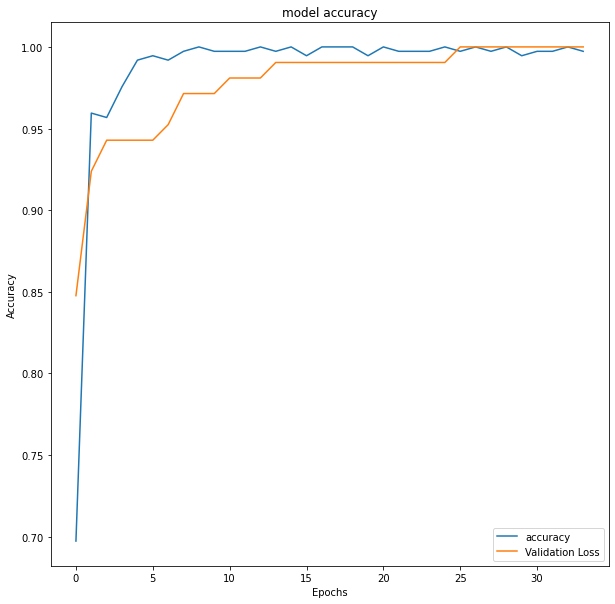

In [181]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy","Validation Loss"])
plt.show()

In [182]:
y_real=[]
all_pred=[]
count=0
for x,y in test:
  predict=final_model.predict(x)
  
  for i in predict:
    
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i=np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test.filepaths):
    break

1/1 [==============================] - 1s 1s/step


In [184]:
target_names =[]
for key,value in test.class_indices.items():
  target_names.append(f'condition: {key}')

In [185]:
from sklearn import metrics
report=metrics.classification_report(y_real,all_pred,target_names=target_names)
conf_efficnet2=metrics.confusion_matrix(y_real,all_pred)

In [186]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=target_names, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return


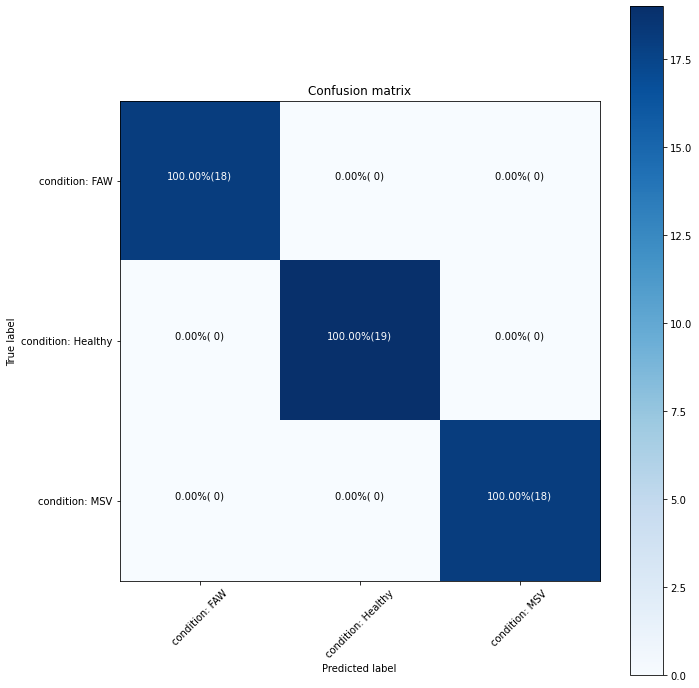

In [187]:
plot_confusion_matrix(conf_efficnet2)

In [169]:
from tensorflow.keras.applications import EfficientNetB3

In [170]:
# hist.predict()

In [188]:
print(test.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [189]:
preds=final_model.predict(x)

1/1 [==============================] - 1s 1s/step


In [190]:
myPreds=print("predicted class: ", preds )

predicted class:  [[9.33073640e-01 2.51378835e-04 6.66750520e-02]
 [1.57532893e-04 9.99729455e-01 1.12988550e-04]
 [1.00547403e-01 8.63277495e-01 3.61750796e-02]
 [4.06104991e-05 9.99849916e-01 1.09376393e-04]
 [9.96683776e-01 6.55242940e-04 2.66093132e-03]
 [4.71135182e-03 2.64948726e-01 7.30339944e-01]
 [2.32049806e-05 9.99968410e-01 8.34692037e-06]
 [7.23960053e-04 3.14813879e-05 9.99244571e-01]
 [3.13853707e-05 6.72012975e-05 9.99901414e-01]
 [9.81024384e-01 1.47635872e-02 4.21208423e-03]
 [1.30370652e-04 9.99680996e-01 1.88628561e-04]
 [2.46142270e-04 9.99061882e-01 6.91945781e-04]
 [7.78891408e-05 9.99779880e-01 1.42170684e-04]
 [9.98970628e-01 7.20237222e-05 9.57312994e-04]
 [4.58132140e-02 1.09866483e-03 9.53088105e-01]
 [9.75104776e-05 1.97906949e-04 9.99704540e-01]
 [1.92652587e-05 4.06588042e-05 9.99940038e-01]
 [9.77447271e-01 1.80775329e-04 2.23720428e-02]
 [9.61050510e-01 1.94912702e-02 1.94582418e-02]
 [9.74410474e-01 3.34127597e-03 2.22482048e-02]
 [9.99798596e-01 1.191

In [191]:
imagesPath = os.listdir(val_file_path + "/MSV")

In [192]:
imagesPath

['1638780599398 (Large).jpg',
 '1638780738656 (Large).jpg',
 '1638780823989 (Large).jpg',
 '1638780842322 (Large).jpg',
 '1638780887067 (Large).jpg',
 '1638780893710 (Large).jpg',
 '1638792490011 (Large).jpg',
 '1638792520397 (Large).jpg',
 '1638792583583 (Large).jpg',
 '1638792600100 (Large).jpg',
 '1638792672367 (Large).jpg',
 '1638792680334 (Large).jpg',
 '1638792764047 (Large).jpg',
 '1638792796419 (Large).jpg',
 '1638792832978 (Large).jpg',
 '1638793025181 (Large).jpg',
 '1638793095979 (Large).jpg',
 '1638793098141 (Large).jpg',
 '1638793204077 (Large).jpg',
 '1638793214452 (Large).jpg',
 '1638793252124 (Large).jpg',
 '1638793311464 (Large).jpg',
 '1638793325493 (Large).jpg',
 '1638793431889 (Large).jpg',
 '1638793512847 (Large).jpg',
 '1638793517419 (Large).jpg',
 '1638793522348 (Large).jpg',
 '1638793529144 (Large).jpg',
 '1638793549908 (Large).jpg',
 '1638793584746 (Large).jpg',
 '1638793610942 (Large).jpg',
 '1638793634345 (Large).jpg',
 '1638793648737 (Large).jpg',
 '16387936

In [193]:
test.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [194]:
print(img_path)

C:/Users/Winner/OneDrive/Documents/AI Hackathon/dataset/input/Healthy/IMG_20211208_120044 (Large).jpg


In [195]:
validation_Path='C:/Users/Winner/OneDrive/Documents/AI Hackathon/dataset/output/val/FAW/1638864093476 (Large).jpg'

(1, 810, 1080, 3)
1/1 [==============================] - 1s 558ms/step
This is fall army worm 


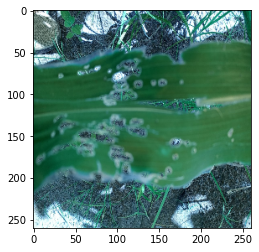

In [196]:
#path = val_file_path + "/MSV/" + "1638780818502 (Large).jpg'"
img = cv2.imread(validation_Path)
img.shape
img_resized = cv2.resize(img, (260, 260))
plt.imshow(img_resized)

img_resized = np.expand_dims(img, axis=0)
img_resized = preprocess_input(img_resized)

print(img_resized.shape)

final_model.predict(img_resized)
print('This is fall army worm ')

In [180]:

type(final_model.predict(img_resized))



1/1 [==============================] - 1s 644ms/step


numpy.ndarray